#Model 3: Conv1D with character embeddings

In [9]:
# Import Libraries

import os
import pickle
import pandas as pd
from helper_functions import calculate_results
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import random
import tensorflow_hub as hub

In [10]:
# Import cleaned Dataset

#clean_dir = '/content/Data/Cleaned_dataset/'
clean_dir = '/content/'

train_df = pd.read_csv(clean_dir + 'train.csv',index_col=False)
val_df = pd.read_csv(clean_dir + 'val.csv',index_col=False)
test_df = pd.read_csv(clean_dir + 'test.csv',index_col=False)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [11]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [12]:
# View first 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [13]:
# One hot encoding labels

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [14]:
# Extract labels ("target" columns) and encode them into integers

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [15]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))


In [16]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [17]:
# What's the average character length?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

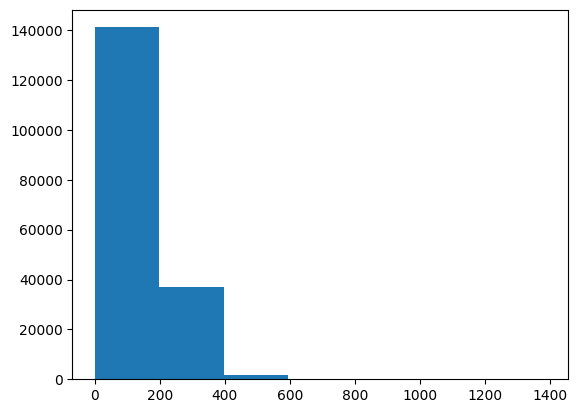

In [18]:
# Check the distribution of our sequences at character-level

import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [19]:
# Find what character length covers 95% of sequences

output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [20]:
# Get all keyboard characters for char-level embedding

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [22]:
# Check character vocabulary characteristics

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [23]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n c r e a s e d   a c t i v i t y   i n   t h e   -   f r e q u e n c y   r a n g e   (   @ - @   h z   )   w a s   o b s e r v e d   e m e r g i n g   a n d   g r a d u a l l y   a c c u m u l a t i n g   @   s   b e f o r e   a   m i s s e d   t a r g e t   .

Length of chars: 109

Vectorized chars:
[[ 4  6 11  8  2  5  9  2 10  5 11  3  4 21  4  3 19  4  6  3 13  2 17  8
   2 26 16  2  6 11 19  8  5  6 18  2 13 25 20  5  9  7 22  9  2  8 21  2
  10  2 15  2  8 18  4  6 18  5  6 10 18  8  5 10 16  5 12 12 19  5 11 11
  16 15 16 12  5  3  4  6 18  9 22  2 17  7  8  2  5 15  4  9  9  2 10  3
   5  8 18  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0

In [24]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n c r e a s e d   a c t i v i t y   i n   t h e   -   f r e q u e n c y   r a n g e   (   @ - @   h z   )   w a s   o b s e r v e d   e m e r g i n g   a n d   g r a d u a l l y   a c c u m u l a t i n g   @   s   b e f o r e   a   m i s s e d   t a r g e t   .

Embedded chars (after vectorization and embedding):
[[[ 0.00139307 -0.01246476  0.02129791 ...  0.04322261 -0.01044513
   -0.04305243]
  [-0.03414915 -0.01944592  0.02756578 ... -0.03402773 -0.00441483
   -0.01648943]
  [-0.03809164  0.04696095  0.01803048 ...  0.02486149  0.01658266
    0.02117635]
  ...
  [-0.03304897  0.01887977 -0.0044743  ... -0.04972421  0.04234146
    0.00228288]
  [-0.03304897  0.01887977 -0.0044743  ... -0.04972421  0.04234146
    0.00228288]
  [-0.03304897  0.01887977 -0.0044743  ... -0.04972421  0.04234146
    0.00228288]]]

Character embedding shape: (1, 290, 25)


In [25]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [28]:
# Make Conv1D on chars only
num_classes = 5

inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [29]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 5

In [30]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 9ms/step - loss: 1.2519 - accuracy: 0.4936 - val_loss: 1.0370 - val_accuracy: 0.5851
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9995 - accuracy: 0.6023 - val_loss: 0.9387 - val_accuracy: 0.6336
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9210 - accuracy: 0.6399 - val_loss: 0.8702 - val_accuracy: 0.6649


In [31]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8828 - accuracy: 0.6607


[0.8828418850898743, 0.6606977581977844]

In [32]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.21559766, 0.22540955, 0.13230966, 0.34784657, 0.07883649],
       [0.1637527 , 0.68800265, 0.01319731, 0.06350054, 0.07154674],
       [0.11422724, 0.35687572, 0.17209022, 0.29566818, 0.06113861],
       ...,
       [0.05102926, 0.05631462, 0.1848874 , 0.05366999, 0.6540987 ],
       [0.02511756, 0.09394985, 0.1429547 , 0.02103594, 0.71694195],
       [0.4888737 , 0.27757743, 0.09422271, 0.12419149, 0.01513479]],
      dtype=float32)

In [33]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 4, 0])>

In [34]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.06977359989408,
 'precision': 0.6500870575591053,
 'recall': 0.6606977359989408,
 'f1': 0.6498619969734701}

<Axes: >

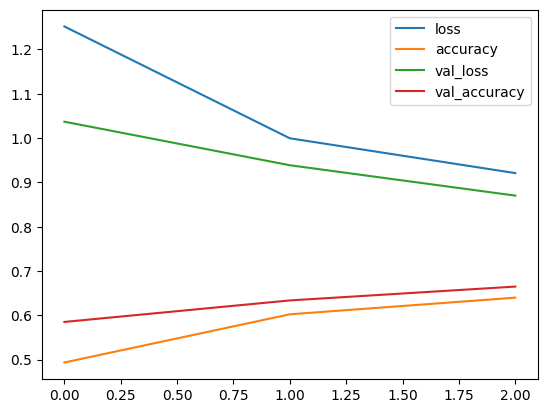

In [35]:
pd.DataFrame(model_3_history.history).plot()

In [36]:
# Export results for later comparison

with open('/content/model_3_results.pickle', 'wb') as f:
    pickle.dump(model_3_results, f)